# Collocation grids

The grid discretizes the computational domain into collocation nodes.

Likely all the documentation concerning these grids relevant for non-developer users can be found [here](https://desc-docs.readthedocs.io/en/latest/notebooks/basis_grid.html#Collocation-grids).

The purpose of this notebook is to clarify design choices in `grid.py`.
This will let new developers learn and maintain the code faster.

The grid has 2 jobs.

- Node placement
- Node weighting
    - Node volume
    - Node areas
    - Node thickness / lengths

This guide will first discuss these two topics in detail.
Then it will show an example of a common operation which relies on node weights.
This will provide a necessary background before we discuss implementation details.

## Node placement

To begin, the user can choose from three grid types: `LinearGrid`, `QuadratureGrid`, and `ConcentricGrid`.
There is also functionality to allow the user to choose how to discretize the computational domain with a grid which has a custom set of nodes.

One difference between the three predefined grids is the placement of nodes.
All the predefined grids linearly space each $\theta$ and $\zeta$ surface.
That is, on any given $\zeta$ surface, all the nodes which lie on the same $\rho$ surface are evenly spaced.
On any given $\theta$ surface, all the nodes which lie on the same $\rho$ surface are evenly spaced.
`LinearGrid`s in particular, also linearly spaces the $\rho$ surfaces.<sup>1</sup>
As the nodes are evenly spaced in all coordinates, each node occupies the same volume in the domain.

See the $\zeta$ cross sections below as a visual.

Footnote [1]: If an array is given as input for the `rho` parameter, then sometimes the `rho` surfaces are not given equal $d\rho$.
This will be discussed later in the guide.

In [ ]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from desc.equilibrium import Equilibrium
from desc.examples import get
from desc.grid import *
from desc.plotting import plot_grid

import warnings

warnings.filterwarnings("ignore")
np.set_printoptions(precision=3, floatmode="fixed")

(<Figure size 384x384 with 1 Axes>,
 <PolarAxes: title={'center': 'ConcentricGrid, $M=3$, pattern: jacobi'}>)

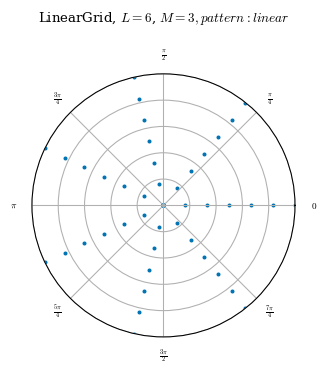

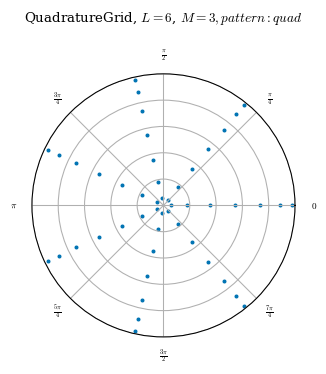

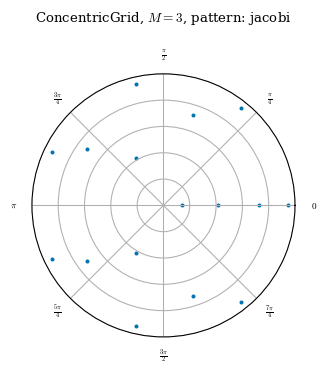

In [2]:
L, M, N = 6, 3, 1
lg = LinearGrid(L, M, N)
qg = QuadratureGrid(L, M, N)
cg = ConcentricGrid(L, M, N)

plot_grid(lg)
plot_grid(qg)
plot_grid(cg);

Regarding node placement, the only difference between `QuadratureGrid` and `LinearGrid` is that `QuadratureGrid` does not evenly space the flux surfaces.

As can be seen above, although the `ConcentricGrid` has nodes evenly spaced on each $\theta$ curve, the number of nodes on each $\theta$ curve is not constant.
On `ConcentricGrid`s, the number of nodes per $\rho$ surface decreases toward the axis.
The number of nodes on each $\theta$ surface is also not constant and will change depending on the `node_pattern` as documented [here](https://desc-docs.readthedocs.io/en/latest/notebooks/basis_grid.html#Concentric-grids).

### Caution on different grid types
These differences between the grid types regarding the spacing of surfaces are important to consider in the context of certain computations.
For example the correctness of integrals or averages along a given surface will depend on the grid type.
If a grid does not evenly space each $\theta$ surface, then some $\theta$ surfaces will be assigned a different "thickness" (i.e. a larger d$\theta$).
A flux surface average on such a grid would then assign more weight to nodes on some $\theta$ coordinates than others.
This may introduce an error to the computation of an average as some locations on the surface would have more weight than others.

## Structure of computed quantities

The number of nodes in any given grid is stored in the `num_nodes` attribute.
The grid object itself is a `num_nodes` $\times$ 3 numpy array.
That is `num_nodes` rows and 3 columns.
Each row of the grid represents a single node.
The three columns give the $\rho, \theta, \zeta$ coordinates, respectively, of any node.

All quantities that are computed by DESC are either a global scalar or an array with the same number of rows as the grid the quantity was computed on.
For example, we can think of `nodes` as a vector which is the input to any function $f(\text{nodes})$.
The output $f(\text{nodes})$ is a vector-valued function which evaluates the function at each node.
See below for a visual.

In [3]:
eq = get("HELIOTRON")
grid = QuadratureGrid(L=2, M=1, N=1, NFP=eq.NFP)
data = eq.compute(["B", "psi"], grid=grid)

print("     grid nodes          ", "ψ", "             B")
for node, psi, b in zip(grid.nodes, data["psi"], data["B"]):
    print(node, "  ", np.asarray([psi]), "  ", b)

     grid nodes           ψ              B
[0.212 0.000 0.000]    [0.007]    [2.708e-18 3.534e-01 3.555e-02]
[0.212 2.094 0.000]    [0.007]    [0.047 0.317 0.060]
[0.212 4.189 0.000]    [0.007]    [-0.047  0.317  0.060]
[0.591 0.000 0.000]    [0.056]    [-5.055e-18  3.830e-01 -4.191e-02]
[0.591 2.094 0.000]    [0.056]    [0.136 0.378 0.050]
[0.591 4.189 0.000]    [0.056]    [-0.136  0.378  0.050]
[0.911 0.000 0.000]    [0.132]    [-2.726e-17  2.630e-01 -7.147e-02]
[0.911 2.094 0.000]    [0.132]    [0.222 0.364 0.061]
[0.911 4.189 0.000]    [0.132]    [-0.222  0.364  0.061]
[0.212 0.000 0.110]    [0.007]    [-0.026  0.366 -0.011]
[0.212 2.094 0.110]    [0.007]    [-0.063  0.326 -0.006]
[0.212 4.189 0.110]    [0.007]    [-0.050  0.374 -0.073]
[0.591 0.000 0.110]    [0.056]    [0.056 0.419 0.060]
[0.591 2.094 0.110]    [0.056]    [-0.031  0.311  0.050]
[0.591 4.189 0.110]    [0.056]    [-0.025  0.374 -0.123]
[0.911 0.000 0.110]    [0.132]    [0.177 0.409 0.141]
[0.911 2.094 0.110]    [0.1

The leftmost block are the nodes of the grid.

The middle block is a flux surface function.
In particular $\psi$ is a scalar function of the coordinate $\rho$.
We can see $\psi$ is constant over all nodes which have the same value for the $\rho$ coordinate.

The rightmost block is the magnetic field vector.
The columns give the $\rho, \theta, \zeta$ components of this vector.
Each row is the evaluation of the magnetic field vector at the node on that same row.

### Node order
The nodes in all predefined grids are also sorted.
The ordering sorts the coordinates with the following order with decreasing priority: $\zeta, \rho, \theta$.
As shown above, this means the first chunk of a grid represents a zeta surface.
Within that $\zeta$ surface, the first chunk represents the intersection of a $\rho$ surface and $\zeta$ surface (i.e. a $\theta$ curve).
Then within that are the nodes along that $\theta$ curve.

## Node weight invariants

Each node occupies a certain volume in the computational domain which depends on the placement of the neighboring nodes.
Nodes with larger volume occupy more of the computational domain and should therefore be weighted more heavily in any computation that evaluates a quantity over multiple nodes, such as surface averages.

All grids have two relevant attributes for this.
The first is `weights`, which corresponds to the volume differential element $dV$ in the computational domain.
The second is `spacing`, which corresponds to the three surface differential elements $d\rho$, $d\theta$, and $d\zeta$.

### Node volume
If the entire computational space was represented by 1 node, this node would need to span the domain of each coordinate entirely.
The node would need to cover every
- $\rho$ surface from 0 to 1, so it must occupy a radial length of $d\rho = 1$
- $\theta$ surface from 0 to 2$\pi$, so it must occupy a poloidal length of $d\theta = 2\pi$
- $\zeta$ surface from 0 to 2$\pi$, so it must occupy a toroidal length of $d\zeta = 2\pi$

Hence the total volume of the node is $dV = d\rho \times d\theta \times d\zeta = 4\pi^2$.
If more nodes are used to discretize the space, then the sum of all the nodes' volumes must equal $4\pi^2$.
We require
$$\int_0^1 \int_0^{2\pi}\int_0^{2\pi} d\rho d\theta d\zeta = 4\pi^2$$

### Node areas
Every $\rho$ surface has a total area of
$$\int_0^{2\pi}\int_0^{2\pi} d\theta d\zeta = 4\pi^2$$
Every $\theta$ surface has a total area of
$$\int_0^{1}\int_0^{2\pi} d\rho d\zeta = 2\pi$$
Every $\zeta$ surface has a total area of
$$\int_0^{1}\int_0^{2\pi} d\rho d\theta = 2\pi$$

If S is the set of all the nodes on a particular surface in a given grid, then the sum of each node's contribution to that surface's area must equal the total area of that surface.

#### Actual area of a surface

You may ask:
> The $\zeta$ surfaces are disks in the computational domain. Shouldn't any integral over the radial coordinate include an area Jacobian of $\rho$, so that $\int_0^{1}\int_0^{2\pi} \rho d\rho d\zeta = \pi$?

If we wanted to compute the actual area of a $\zeta$ surface, we would weight it by the area Jacobian for that surface in our geometry:
$$\int_0^1 \int_0^{2\pi} \lvert \ e_{\rho} \times e_{\theta} \rvert d\rho d\theta$$

When we mention "node area" in this document, we are just referring to the product of the differential elements in the columns of `grid.spacing` for the row associated with that node. For a $\zeta$ surface the unweighted area, which is the sum of these products over all the nodes on the surface, would be $$\int_0^1 \int_0^{2\pi} d\rho d\theta = 2\pi$$

That is an invariant the grid should try to keep. That way when we supply a Jacobian factor in the integral, whether that be for an area or volume, we know that the integral covers the entire domain.

### Node thickness / lengths

We require
$$\int_0^{1} d\rho = 1$$
$$\int_0^{2\pi} d\theta = 2\pi$$
$$\int_0^{2\pi} d\zeta = 2\pi$$
where the integrals can be over any $\rho$, $\theta$, or $\zeta$ curve.

These are the invariants that `grid.py` needs to maintain when constructing a grid.

### Visual: `grid.weights` and `grid.spacing`

Let's see a visual of the `weights` and `spacing` for `LinearGrid`.
Recall that `LinearGrid` evenly spaces every surface, and therefore each node should have the same volume and area contribution for every surface.

In [4]:
def print_grid_weights(grid):
    print("     grid nodes         ", "dV", "         d𝜌    d𝜃    d𝜁")
    for node, weight, spacing in zip(grid.nodes, grid.weights, grid.spacing):
        print(node, "  ", np.asarray([weight]), "  ", spacing)
    print()
    print()


print("Notice the invariants mentioned above are maintained in the examples below.\n")

print("The most basic example: 2 node LinearGrid")
print_grid_weights(LinearGrid(L=1, M=0, N=0))

lg = LinearGrid(L=2, M=1, N=0)
print("A LinearGrid with only 1 𝜁 cross section")
print(
    "Notice the 𝜁 surface area is the sum(d𝜌 X d𝜃):",
    lg.spacing[:, :2].prod(axis=1).sum(),
)
print_grid_weights(lg)

print("A low resolution LinearGrid")
print_grid_weights(LinearGrid(L=2, M=1, N=1))

print("A ConcentricGrid with only 1 𝜁 cross section")
print(
    "Notice the node which composes a 𝜌 surface by itself has more weight than any node on a surface with multiple nodes."
)
print("The method of assigning this weight will be discussed later")
print_grid_weights(ConcentricGrid(L=2, M=2, N=0))

Notice the invariants mentioned above are maintained in the examples below.

The most basic example: 2 node LinearGrid
     grid nodes          dV          d𝜌    d𝜃    d𝜁
[0.000 0.000 0.000]    [19.739]    [0.500 6.283 6.283]
[1.000 0.000 0.000]    [19.739]    [0.500 6.283 6.283]


A LinearGrid with only 1 𝜁 cross section
Notice the 𝜁 surface area is the sum(d𝜌 X d𝜃): 6.283185307179585
     grid nodes          dV          d𝜌    d𝜃    d𝜁
[0.000 0.000 0.000]    [4.386]    [0.333 2.094 6.283]
[0.000 2.094 0.000]    [4.386]    [0.333 2.094 6.283]
[0.000 4.189 0.000]    [4.386]    [0.333 2.094 6.283]
[0.500 0.000 0.000]    [4.386]    [0.333 2.094 6.283]
[0.500 2.094 0.000]    [4.386]    [0.333 2.094 6.283]
[0.500 4.189 0.000]    [4.386]    [0.333 2.094 6.283]
[1.000 0.000 0.000]    [4.386]    [0.333 2.094 6.283]
[1.000 2.094 0.000]    [4.386]    [0.333 2.094 6.283]
[1.000 4.189 0.000]    [4.386]    [0.333 2.094 6.283]


A low resolution LinearGrid
     grid nodes          dV          d𝜌    

## A common operation which relies on node area: surface integrals

Many quantities of interest require an intermediate computation in the form of an integral over a surface:
$$integral(Q) = \int_0^{2\pi}\int_0^{2\pi} d\theta d\zeta \ Q = \sum_{i} d\theta d\zeta \ Q$$

The steps to perform this computation are:
1. Compute the integrand with the following element wise product.
Recall that the first two terms in the product are $d\theta$ and $d\zeta$.
Repeating a previous remark: we can think of `nodes` as a vector which is the input to a function $f(nodes)$.
In this case $f$ is `integrand_function`. The output $f(nodes)$ evaluates the function at each node.
```python
integrand_function = grid.spacing[:, 1] * grid.spacing[:, 2] * Q
```
2. Filter `integrand_function` so that it only includes the values of the function evaluated on the desired surface.
In other words, we need to downsample `integrand_function` from $f(nodes)$ to $f(nodes \ on \ desired \ surface)$.
This requires searching through the grid and collecting the indices of each node with the same value of the desired surface label.
```python
desired_rho_surface = 0.5
indices = np.where(grid.nodes[:, 0] == desired_rho_surface)[0]
integrand_function = integrand_function[indices]
```
3. Compute the integral by taking the sum.
```python
integral = integrand_function.sum()
```

To evaluate $integral(Q)$ on a different surface, we would need to repeat steps 2 and 3, making sure to collect the indices corresponding to that surface.
With grids of different types that can include many surfaces, this process becomes a chore.
Fortunately, there exists a utility function that performs these computations efficiently in bulk.
The code
```python
integrals = surface_integrals(grid=grid, q=Q, surface_label="rho")
```
would perform the above algorithm while also upsampling the result back to a length that is broadcastable with other quantities.

We may think of `surface_integrals` as a function, $g$, which takes the nodes of a grid as an input, i.e. $g(nodes)$, and returns an array of length `grid.num_nodes` which is $g$ evaluated on each node of the grid.
This lets computations of the following form be simple element wise products in code.
$$H = \psi \lvert B \rvert \int_0^{2\pi}\int_0^{2\pi} d\theta d\zeta \ Q$$
```python
H = data["psi"] * data["|B|"] * surface_integrals(grid=grid, q=Q, surface_label="rho")
```

Below is a visual of the output generated by `surface_integrals`.

### Visual: `surface_integrals`

In [5]:
from desc.integrals import surface_integrals

grid = QuadratureGrid(L=2, M=1, N=1, NFP=eq.NFP)
B = eq.compute("|B|", grid=grid)["|B|"]
B_integrals = surface_integrals(grid=grid, q=B, surface_label="rho")

print("Notice that nodes with the same 𝜌 coordinate share the same output value.")
print("     grid nodes       ", "𝜌 surface integrals of |B|")
for node, B_integral in zip(grid.nodes, B_integrals):
    print(node, "       ", np.asarray([B_integral]))

Notice that nodes with the same 𝜌 coordinate share the same output value.
     grid nodes        𝜌 surface integrals of |B|
[0.212 0.000 0.000]         [13.923]
[0.212 2.094 0.000]         [13.923]
[0.212 4.189 0.000]         [13.923]
[0.591 0.000 0.000]         [15.226]
[0.591 2.094 0.000]         [15.226]
[0.591 4.189 0.000]         [15.226]
[0.911 0.000 0.000]         [14.889]
[0.911 2.094 0.000]         [14.889]
[0.911 4.189 0.000]         [14.889]
[0.212 0.000 0.110]         [13.923]
[0.212 2.094 0.110]         [13.923]
[0.212 4.189 0.110]         [13.923]
[0.591 0.000 0.110]         [15.226]
[0.591 2.094 0.110]         [15.226]
[0.591 4.189 0.110]         [15.226]
[0.911 0.000 0.110]         [14.889]
[0.911 2.094 0.110]         [14.889]
[0.911 4.189 0.110]         [14.889]
[0.212 0.000 0.220]         [13.923]
[0.212 2.094 0.220]         [13.923]
[0.212 4.189 0.220]         [13.923]
[0.591 0.000 0.220]         [15.226]
[0.591 2.094 0.220]         [15.226]
[0.591 4.189 0.220]      

## Grid construction

As the above example implies, it is important that correct values for node spacing are maintained for accurate computations.
This section gives a high-level discussion of how grids are constructed in `grid.py` and how the invariants mentioned above for spacing and weights are preserved.

The code is modular enough that the function calls in the `__init__` method of any grid type should provide a good outline.
In any case, the main steps are:
1. Massaging input parameters to protect against weird user inputs.
1. Placing the nodes in a specified pattern.
2. Assigning spacing and weight to the nodes based on placement of nodes and their neighbors.
4. Enforcing symmetry if it was specified by the user.
5. Post processing to assign useful things as attributes to the grid.

`LinearGrid` is the grid which is most instructive to give a walk-through on.
The construction process for`QuadratureGrid` and `ConcentricGrid` are similar, with the only difference being that they place the nodes differently in the `create_nodes` function.

There are two ways to specify how the nodes are placed on `LinearGrid`.

The first method is to specify numbers for the parameters `rho`, `theta`, or `zeta` (or `L`, `M`, `N` which stand for the radial, poloidal, and toroidal grid resolution, respectively).
The second method is to specify arrays for the parameters `rho`, `theta`, or `zeta`.

### $\rho$ spacing

When we give numbers for any of these parameters (e.g. `rho=8`), we are specifying that we want the grid to have that many surfaces (e.g. 8 $\rho$ surfaces) which are spaced equidistant from one another with the same $d\rho$ weight.
Hence, each $\rho$ surface should have $d\rho = 1 / 8$.
The relevant code for this is below.
```python
r = np.flipud(np.linspace(1, 0, int(rho), endpoint=axis))
dr = 1 / r.size * np.ones_like(r)
```

When we give arrays for any of these parameters (e.g. `rho=[0.125, 0.375, 0.625, 0.875]`), we are specifying that we want the grid to have surfaces at those coordinates of the given surface label.
In this case the surfaces are assigned equal thickness (i.e. $d\rho$), but that is not always the case.
The rule to compute the thickness when an array is given is that the cumulative sums of d$\rho$ are node midpoints.
In terms of how $d\rho$ is used as a "thickness" for an interval in integrals, this is similar to a midpoint Riemann sum.

In the above example, for the first surface we have
$$(d\rho)_1 = mean(0.125, 0.375) = 0.25$$
For the second surface we have
$$(d\rho)_1 + (d\rho)_2 = mean(0.375, 0.625) = 0.5 \implies (d\rho)_2 = 0.25$$
Continuing this rule will show that each surface is weighted equally with a thickness of $d\rho = 0.25$.
The algorithm for this is below.
```python
# r is the supplied array for rho
# choose dr such that cumulative sums of dr[] are node midpoints and the total sum is 1
dr[0] = (r[0] + r[1]) / 2
dr[1:-1] = (r[2:] - r[:-2]) / 2
dr[-1] = 1 - (r[-2] + r[-1]) / 2
```

If instead the supplied parameter was `rho=[0.25, 0.75]` then each surface would have a thickness of $d\rho = 0.5$.
An advantage of this algorithm is that the nodes are assigned a good $d\rho$ even if the input array is not evenly spaced.

#### An important point
This touches on an important point.
When an array is given as the parameter for $\rho$, the thickness assigned to each surface is not guaranteed to be equal to the space between the two surfaces.
In contrast to the previous example, if `rho=[0.5, 1]`, then $(d\rho)_1 = 0.75$ for the first surface at $\rho = 0.5$ and $(d\rho)_2 = 0.25$ for the second surface at $\rho = 1$.
The first surface is weighted more because an interval centered around the node $\rho = 0.5$ lies entirely in the boundaries of the domain: [0, 1].
The second surface is weighted less because an interval centered around the node at $\rho = 1$ lies partly outside of the domain.
Since each node is meant to discretize an interval of surfaces around it, nodes at the boundaries of the domain should be given less weight.<sup>2</sup>
As half of any interval around a boundary lies outside the domain.
A visual is provided below.

#### An analogy with a stick
Footnote [2]: If that explanation did not make sense, perhaps this analogy might.
Suppose you want to estimate the temperature of an ideal stick of varying temperature of length 1.
You can shine a laser at any location of the stick to sample the temperature there.
This sample is a good estimate for the temperature of the stick in a small interval around that point.

You pick the center of the stick, $\rho = 0.5$ for your first sample.
You record a temperature of $T_1$.
This is your current estimate for the temperature of the entire stick from $\rho = 0 \ to\ 1$.
You decide to measure the temperature of the stick at one more location $\rho = 1$, recording a temperature of $T_2$.

Now to calculate the mean temperature of the stick, weighing the measurements equally and claiming $T$<sub>average</sub> $= 0.5 * T_1 + 0.5 * T_2$ would be a mistake.
Only the temperature of the stick at the midpoint of the measurements, $\rho = 0.75$, is estimated equally well by either measurement.
The temperature of the stick from $\rho = 0\ to\ 0.75$ is better measured by the first measurement because this portion of the stick is closer to 0.5 than 1.
Hence, a more accurate way to calculate the stick's temperature would be $T$<sub>average</sub> $= 0.75 * T_1 + 0.25 * T_2$

#### Visual: $d\rho$ "spacing"

Both of these nodes have 𝑑𝜌=0.5


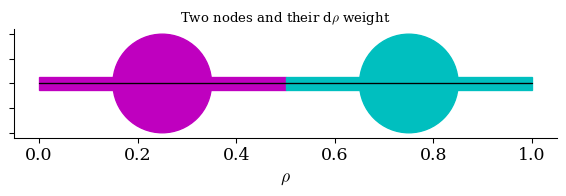

The left node has 𝑑𝜌=0.75, the right has 𝑑𝜌=0.25


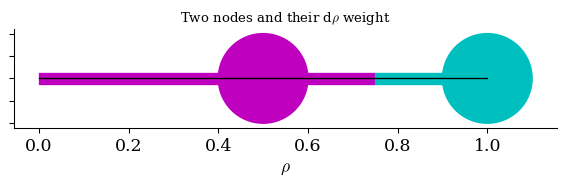

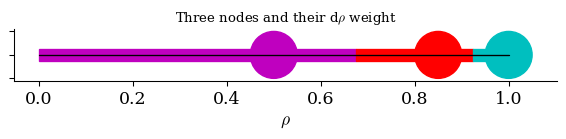

In [6]:
rho = np.linspace(0, 1, 100)

print("Both of these nodes have 𝑑𝜌=0.5")
figure, axes = plt.subplots(1)
axes.add_patch(plt.Circle((0.25, 0), 0.1, color="m"))
axes.add_patch(plt.Circle((0.75, 0), 0.1, color="c"))
axes.add_patch(plt.Rectangle((0, -0.0125), 0.5, 0.025, color="m"))
axes.add_patch(plt.Rectangle((0.5, -0.0125), 0.5, 0.025, color="c"))
axes.plot(rho, np.zeros_like(rho), color="k")
axes.set_aspect("equal")
axes.set_yticklabels([])
plt.title("Two nodes and their d" + r"$\rho$" + " weight")
axes.set_xlabel(r"$\rho$", fontsize=13)
plt.xticks(fontsize=13)
plt.show()

print("The left node has 𝑑𝜌=0.75, the right has 𝑑𝜌=0.25")
figure, axes = plt.subplots(1)
axes.add_patch(plt.Circle((0.5, 0), 0.1, color="m"))
axes.add_patch(plt.Circle((1, 0), 0.1, color="c"))
axes.add_patch(plt.Rectangle((0, -0.0125), 0.75, 0.025, color="m"))
axes.add_patch(plt.Rectangle((0.75, -0.0125), 0.25, 0.025, color="c"))
axes.plot(rho, np.zeros_like(rho), color="k")
axes.set_aspect("equal")
axes.set_yticklabels([])
axes.set_xlabel(r"$\rho$", fontsize=13)
plt.xticks(fontsize=13)
plt.title("Two nodes and their d" + r"$\rho$" + " weight")
plt.show()

figure, axes = plt.subplots(1)
axes.add_patch(plt.Circle((0.5, 0), 0.05, color="m"))
axes.add_patch(plt.Circle((0.85, 0), 0.05, color="r"))
axes.add_patch(plt.Circle((1, 0), 0.05, color="c"))
axes.add_patch(plt.Rectangle((0, -0.0125), 0.675, 0.025, color="m"))
axes.add_patch(plt.Rectangle((0.675, -0.0125), 0.25, 0.025, color="r"))
axes.add_patch(plt.Rectangle((0.925, -0.0125), 0.075, 0.025, color="c"))
axes.plot(rho, np.zeros_like(rho), color="k")
axes.set_aspect("equal")
axes.set_yticklabels([])
axes.set_xlabel(r"$\rho$", fontsize=13)
plt.xticks(fontsize=13)
plt.title("Three nodes and their d" + r"$\rho$" + " weight")
plt.show()

### $\theta$ and $\zeta$ spacing

When a number is provided for any of these parameters (e.g. `theta=8` and `zeta=8`), we are specifying that we want the grid to have that many surfaces (e.g. 8 $\theta$ and 8 $\zeta$ surfaces) which are spaced equidistant from one another with equal $d\theta$ or $d\zeta$ weight.
Hence, each $\theta$ surface should have $d\theta = 2 \pi / 8$.

When we give arrays for any of these parameters (e.g. `theta=np.linspace(0, 2pi, 8)`), we are specifying that we want the grid to have surfaces at those coordinates of the given surface label.

In the preceding discussion about $\rho$ spacing, recall that even if a linearly spaced array is given as input for `rho`, $d\rho$ may not always be the same for every surface, because we computed $d\rho$ so that its cumulative sums were node midpoints.
The reason for doing this was because nodes which lie near the boundaries of $\rho = 0, or\ 1$ should be given less thickness in $d\rho$.
For $\theta$ and $\zeta$ surfaces, the periodic nature of the domain removes the concept of a boundary.
This means any time a linearly spaced array of coordinates is an input, the resulting $d\theta$ or $d\zeta$ will be constant.

The rule used to compute the spacing when an array is given is: $d\theta$ is chosen to be half the cyclic distance of the surrounding two nodes.
In other words, if we parameterize a circle's perimeter from 0 to $2\pi$, and place points on it according to the given array (e.g. `theta = np.linspace(0, 2pi, 4)`), then the $d\theta$ assigned to each node will be half the parameterized distance along the arc between its left and right neighbors.
The process is the same for $\zeta$ spacing.
A visual is provided in the next cell.

The algorithm for this is given in
```python
desc.grid._periodic_spacing
```

An advantage of this algorithm is that the nodes are assigned a good $d\theta$ even if the input array is not evenly spaced.

#### Visual: $\theta$ and $\zeta$ spacing

Here we are visualizing the $d\theta$ spacing of a $\theta$ curve (intersection of $\rho$ and $\zeta$ surface).
Let the node's coordinates be at the values given by the filled circles.
The $d\theta$ spacing assigned to each node is the length of arc of the same color.

Each node is assigned a 𝑑𝜃 of 2𝜋/4


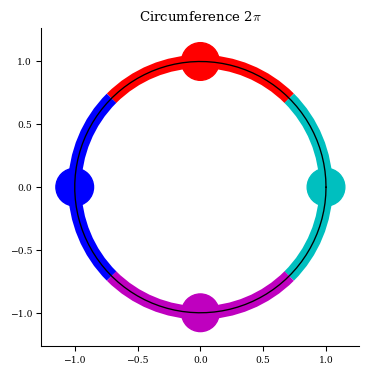

In [7]:
from matplotlib.patches import Arc

print("Each node is assigned a 𝑑𝜃 of 2𝜋/4")
theta = np.linspace(0, 2 * np.pi, 100)
radius = 1
a = radius * np.cos(theta)
b = radius * np.sin(theta)

figure, axes = plt.subplots(1)
axes.plot(a, b, color="k")
axes.add_patch(plt.Circle((0, 1), 0.15, color="r"))
axes.add_patch(plt.Circle((1, 0), 0.15, color="c"))
axes.add_patch(plt.Circle((0, -1), 0.15, color="m"))
axes.add_patch(plt.Circle((-1, 0), 0.15, color="b"))
axes.add_patch(Arc((0, 0), 2, 2, theta1=45, theta2=135, color="r", linewidth=10))
axes.add_patch(Arc((0, 0), 2, 2, theta1=-45, theta2=+45, color="c", linewidth=10))
axes.add_patch(Arc((0, 0), 2, 2, theta1=-135, theta2=-45, color="m", linewidth=10))
axes.add_patch(Arc((0, 0), 2, 2, theta1=135, theta2=225, color="b", linewidth=10))
axes.set_aspect(1)
plt.title("Circumference 2$\pi$")
plt.show()

Non-uniform spacing


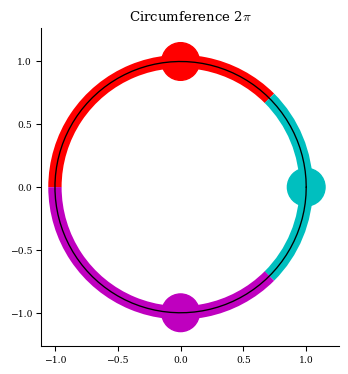

In [8]:
print("Non-uniform spacing")
theta = np.linspace(0, 2 * np.pi, 100)
radius = 1
a = radius * np.cos(theta)
b = radius * np.sin(theta)

figure, axes = plt.subplots(1)
axes.plot(a, b, color="k")
axes.add_patch(plt.Circle((0, 1), 0.15, color="r"))
axes.add_patch(plt.Circle((1, 0), 0.15, color="c"))
axes.add_patch(plt.Circle((0, -1), 0.15, color="m"))
axes.add_patch(Arc((0, 0), 2, 2, theta1=45, theta2=180, color="r", linewidth=10))
axes.add_patch(Arc((0, 0), 2, 2, theta1=-45, theta2=+45, color="c", linewidth=10))
axes.add_patch(Arc((0, 0), 2, 2, theta1=-180, theta2=-45, color="m", linewidth=10))
axes.set_aspect(1)
plt.title("Circumference 2$\pi$")
plt.show()

Two nodes with symmetry set to false


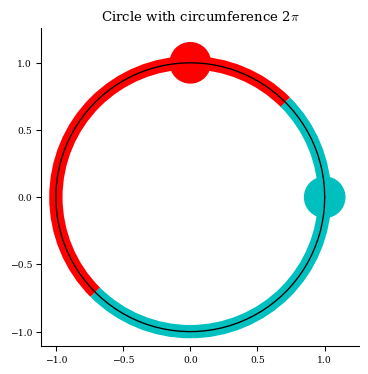

In [9]:
print("Two nodes with symmetry set to false")
theta = np.linspace(0, 2 * np.pi, 100)
radius = 1
a = radius * np.cos(theta)
b = radius * np.sin(theta)

figure, axes = plt.subplots(1)
axes.plot(a, b, color="k")
axes.add_patch(plt.Circle((0, 1), 0.15, color="r"))
axes.add_patch(plt.Circle((1, 0), 0.15, color="c"))
axes.add_patch(Arc((0, 0), 2, 2, theta1=45, theta2=225, color="r", linewidth=10))
axes.add_patch(Arc((0, 0), 2, 2, theta1=-135, theta2=+45, color="c", linewidth=10))
axes.set_aspect(1)
plt.title("Circle with circumference 2$\pi$")
plt.show()

The same two nodes with symmetry set to true
Notice now the red node is given more weight
because there is implicitly a duplicate of that node (in black) across the axis of symmetry.


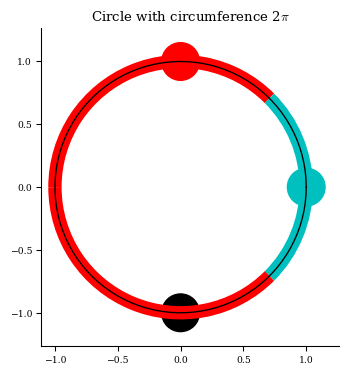

In [10]:
print("The same two nodes with symmetry set to true")
print("Notice now the red node is given more weight")
print(
    "because there is implicitly a duplicate of that node (in black) across the axis of symmetry."
)
theta = np.linspace(0, 2 * np.pi, 100)
radius = 1
a = radius * np.cos(theta)
b = radius * np.sin(theta)

figure, axes = plt.subplots(1)
axes.plot(a, b, color="k")
axes.add_patch(plt.Circle((0, 1), 0.15, color="r"))
axes.add_patch(plt.Circle((1, 0), 0.15, color="c"))
axes.add_patch(plt.Circle((0, -1), 0.15, color="k"))
axes.add_patch(Arc((0, 0), 2, 2, theta1=45, theta2=180, color="r", linewidth=10))
axes.add_patch(Arc((0, 0), 2, 2, theta1=-45, theta2=+45, color="c", linewidth=10))
axes.add_patch(Arc((0, 0), 2, 2, theta1=-180, theta2=-45, color="r", linewidth=10))
axes.set_aspect(1)
plt.title("Circle with circumference 2$\pi$")
plt.show()

## Symmetry

For many stellarators we can take advantage of [stellarator symmetry](https://w3.pppl.gov/~shudson/Papers/Published/1998DH.pdf).
When we set stellarator symmetry on, we delete the extra modes from the basis functions.
This makes equilibrium solves and optimizations faster.

Under this condition, we can usually also delete all the nodes on the collocation grid above the midplane $\theta$ coordinate > $\pi$.<sup>3</sup>
Reducing the size of the grid saves time and memory.

There are some caveats discussed in the next section.
When we delete the nodes above the midplane, we need to preserve the node volume and node area invariants mentioned earlier.
In particular, on any given $\theta$ curve (nodes on the intersection of a constant $\rho$ and constant $\zeta$ surface), the sum of the $d\theta$ of each node should be $2\pi$.
(If this is not obvious, look at the circle illustration above.
The sum of the distance between all nodes on a theta curve sum to $2\pi$).
To ensure this property is preserved, we upscale the $d\theta$ spacing of the remaining nodes.
The upscale factor is given below.
$$d\theta = \frac{2\pi}{\text{number of nodes remaining on that } \theta \text{ curve}} = \frac{2\pi}{\text{number of nodes on that } \theta \text{ curve}} \times \frac{\text{number of nodes on that } \theta \text{ curve}}{\text{number of nodes on that } \theta \text{ curve} - \text{number of nodes to delete on that } \theta \text{ curve}} $$
The term on the left hand side is our desired end result.
The first term on the right is the $d\theta$ spacing that was correct before any nodes were deleted.
The second term on the right is the upscale factor.

For `LinearGrid` this scale factor is a constant which is the same for every $\theta$ curve.
However, recall that `ConcentricGrid` has a decreasing number of nodes on every $\rho$ surface, and hence on every $\theta$ curve, as $\rho$ decreases toward the axis.
This poses an additional complication because it means the "number of nodes to delete" in the denominator of the rightmost fraction above is a different number on each $\theta$ curve.

After the initial grid construction process described earlier, all grid types have a call to a function named `enforce_symmetry()` which
1. identifies all nodes with coordinate $\theta > \pi$ and deletes them from the grid
2. properly computes this scale factor for each $\theta$ curve
    - The assumption is made that the number of nodes to delete on a given $\theta$ curve is constant over $\zeta$.
      This is the same as assuming that each $\zeta$ surface has nodes patterned in the same way, which is an assumption
      we can make for the predefined grid types.
3. upscales the remaining nodes' $d\theta$ weight

Specifically, we upscale the $d\theta$ spacing of any node with $\theta$ coordinate not a multiple of $\pi$, (those that are off the symmetry line), so that these nodes' spacings account for the node that is their reflection across the symmetry line.

Footnote [3]: We could also instead delete all the nodes with $\zeta$ coordinate > $\pi$.

### Why does upscaling $d\theta$ work?

Deleting all the nodes with $\theta$ coordinate > $\pi$ leaves a grid where each $\rho$ and $\zeta$ surface has less area than it should.
By upscaling the nodes' $d\theta$ weights we can recover this area.
It also helps to consider how this affects surface integral computations.

After deleting the nodes, but before upscaling them we are missing perhaps $1/2$ of the $d\theta$ weight.
So if we performed a flux surface integral over the grid in this state, we would be computing
$$ \int_0^{\pi}\int_0^{2\pi} d\theta d\zeta Q\ + 0 \times \int_{\pi}^{2\pi}\int_0^{2\pi} d\theta d\zeta Q \approx \int_0^{2\pi}\int_0^{2\pi} (\frac{1}{2} d\theta) \ d\zeta \ Q$$

The approximate equality follows from the assumption that $Q$ is stellarator symmetric. Clearly the integrals over $\rho$ and $\zeta$ surfaces would be off by some factor.
Notice that upscaling $d\theta$ alone is enough to recover the correct integrals.
This should make sense as deleting all the nodes with $\theta$ coordinate > $\pi$ does not change the number of nodes over any $\theta$ surfaces $\implies$ integrals over $\theta$ surfaces are not affected.

### Poloidal midplane symmetry is not stellarator symmetry

The caveat mentioned above with deleting nodes above the midplane is discussed here.
Recall from `R.L. Dewar, S.R. Hudson, Stellarator symmetry, doi 10.1016/S0167-2789(97)00216-9`, that stellarator symmetry is a property of a curvilinear coordinate system, $(\rho, \theta, \zeta)$, such that $f(\rho, \theta, \zeta) = f(\rho, -\theta, -\zeta)$ `Dewar, Hudson eq.8`. The DESC coordinate system will be a stellarator symmetric coordinate system if the Fourier expansion of the flux surfaces have either the cosine or sine symmetry.

Now, assuming stellarator symmetry gives the first relation
$$f(\rho, -\theta, -\zeta) = f(\rho, \theta, \zeta) \neq f(\rho, -\theta, \zeta \neq 0)$$
but the second relation does not follow (hence the $\neq$). So we should not expect any of our computations to be invariant to truncating the poloidal domain to above the midplane $\theta \in [0, \pi] \subset [0, 2 \pi)$.

If we are computing some function $g \colon \rho, \theta, \zeta \mapsto g(\rho, \theta, \zeta)$ that is just a pointwise evaluation of the basis functions, then we will of course still compute $g$ accurately above the midplane. However, if we are computing any function that is not a pointwise evaluation of the basis function, i.e. a function whose input takes multiple nodes as input and performs some type of reduction, e.g. $F \colon \rho, \theta, \zeta \mapsto \int f(\rho, \theta, \zeta) d S$, then in general $F$ will not be computed accurately if the computational domain is truncated to above the midplane.

In general, given

1. $f$ that evaluates the basis functions pointwise
1. $F$ that performs a reduction on $f$
2. stellarator symmetry: $f(\rho, \theta, \zeta) = f(\rho, -\theta, -\zeta)$
  
then $F$ is guaranteed to be able to be computed accurately on the truncated domain of computation $\theta \in [0, \pi] \subset [0, 2\pi)$ only[^1] if $F$ is a linear reduction over $D \equiv [0, \pi] \times [0, 2 \pi) \ni (\theta, \zeta)$.

> This means that if $F$ is a flux surface integral or volume integral of $f$, then it can be computed on grids that have nodes only above the midplane, i.e. grids such that `grid.sym == True`.

If $F$ is a nonlinear reduction or any reduction that is over a proper subset of $D$, then $F$ may not be computed accurately when the domain is truncated to above the midplane unless there is the additional symmetry
$$f(\rho, \theta, \zeta) = f(\rho, -\theta, \zeta)$$
Stellarator symmetry implies this relation holds for $\zeta = 0$. Therefore, stellarator symmetry and $\partial f / \partial \zeta = 0$ is sufficient, but not necessary, for this additional symmetry.

> This means that if $F$ is a non-flux surface integral or line integral, then it cannot be computed accurately on grids that have nodes only above the midplane, i.e. grids such that `grid.sym == True`, unless the additional symmetry is satisfied.

## On NFP: the number of field periods
The number of field periods measures how often the stellarator geometry repeats over the toroidal coordinate.
If NFP is an integer, then all the relevant information can be determined from analyzing the chunk of the device that spans from $\zeta = 0$ to $\zeta = 2\pi / \text{NFP}$.
So we can limit the toroidal domain (the $\zeta$ coordinates of the grid nodes) at $\zeta = 2\pi / \text{NFP}$.

In regards to the grid, this means after the grid is constructed according to the node placement and spacing rules above, we need to modify the locations of the $\zeta$ surfaces.
We scale down the $\zeta$ coordinate of all the nodes in a grid by a factor of NFP.
If there were $N \ \zeta$ surfaces before, there are still that many - we do not want to change the resolution of the grid.
The locations of the zeta surfaces are just more densely packed together within $\zeta = 0 \ to \ 2\pi / \text{NFP}$.

Note that we do not change the $d\zeta$ weight assigned to each surface just because there is less space between the surfaces.
The quick way to justify this is because scaling down $d\zeta$ would break the invariant we discussed earlier that the total volume or `grid.weights.sum()` equals 4$\pi^2$.

Another argument follows.
Supposing we did scale down $d\zeta$ by NFP, then we would have surface integrals of the form $\int_0^{2\pi}\int_0^{2\pi} d\theta (\frac{d\zeta}{\text{NFP}}) Q$.
The results for these computations would depend on NFP, which is not desirable.
For example, a device which repeats its geometry twice toroidally has NFP = 2.
After $\zeta = 2 \pi / \text{NFP}$, the same pattern restarts.
Of course, you could claim every device has NFP = 1 because $\zeta$ is periodic.
After $\zeta = 2 \pi$, the same pattern restarts.
In this sense any device with NFP >= 2, also could be said to have NFP = 1.
If the result of the above computation depended on NFP, then the computed result would be different on the same device depending on your arbitrary choice of defining where it repeats.

To emphasize: the columns of `grid.spacing` do not correspond to the distance between coordinates of nodes.
Instead they correspond to the differential element weights $d\rho, d\theta, d\zeta$.
These differential element weights should have whatever values are needed to maintain the node volume and area invariants discussed earlier.
The docstring of `grid.spacing` defines this attribute as

        Quadrature weights for integration over surfaces.

        This is typically the distance between nodes when ``NFP=1``, as the quadrature
        weight is by default a midpoint rule. The returned matrix has three columns,
        corresponding to the radial, poloidal, and toroidal coordinate, respectively.
        Each element of the matrix specifies the quadrature area associated with a
        particular node for each coordinate. I.e. on a grid with coordinates
        of "rtz", the columns specify dρ, dθ, dζ, respectively. An integration
        over a ρ flux surface will assign quadrature weight dθ*dζ to each node.
        Note that dζ is the distance between toroidal surfaces multiplied by ``NFP``.

        On a LinearGrid with duplicate nodes, the columns of spacing no longer
        specify dρ, dθ, dζ. Rather, the product of each adjacent column specifies
        dρ*dθ, dθ*dζ, dζ*dρ, respectively.

Below the issue of duplicate nodes are discussed.

## Duplicate nodes

When grids are created by specifying `endpoint=True`, or inputting an array which has both 0 and $2\pi$ as the input to the `theta` and `zeta` parameters, a grid is made with duplicate surfaces.
```python
# if theta and zeta are scalers
t = np.linspace(0, 2 * np.pi, int(theta), endpoint=endpoint)
...
z = np.linspace(0, 2 * np.pi / self.NFP, int(zeta), endpoint=endpoint)
...
r, t, z = np.meshgrid(r, t, z, indexing="ij")
r = r.ravel()
t = t.ravel()
z = z.ravel()
nodes = np.column_stack([r, t, z])
```

The extra value of $\theta = 2 \pi$ and/or $\zeta = 2\pi / \text{NFP}$ in the array duplicates the $\theta = 0$ and/or $\zeta = 0$ surfaces.
There is a surface at $\theta = 0 \text{ or } 2\pi$ with duplicity 2.
There is a surface at $\zeta = 0 \text{ or } 2\pi / \text{NFP}$ with duplicity 2.

There are no duplicate nodes on `ConcentricGrid` or `QuadratureGrid`.

In [11]:
lg = LinearGrid(L=1, N=1, M=1, endpoint=True)
print("A grid with duplicate surfaces")
print("     grid nodes       ")
print("   𝜌      𝜃      𝜁")
print(lg.nodes)

A grid with duplicate surfaces
     grid nodes       
   𝜌      𝜃      𝜁
[[0.000 0.000 0.000]
 [0.000 3.142 0.000]
 [0.000 6.283 0.000]
 [1.000 0.000 0.000]
 [1.000 3.142 0.000]
 [1.000 6.283 0.000]
 [0.000 0.000 3.142]
 [0.000 3.142 3.142]
 [0.000 6.283 3.142]
 [1.000 0.000 3.142]
 [1.000 3.142 3.142]
 [1.000 6.283 3.142]
 [0.000 0.000 6.283]
 [0.000 3.142 6.283]
 [0.000 6.283 6.283]
 [1.000 0.000 6.283]
 [1.000 3.142 6.283]
 [1.000 6.283 6.283]]


### The problem with duplicate nodes

For the above grid, all the nodes are located in two cross-sections at $\zeta = 0 \text{ and } \pi$.
However the $\zeta = 0$ surface has twice as many nodes as the $\zeta = \pi$ surface because of the duplicate surface at $\zeta = 2\pi$.

If we wanted to sum a function which was 1 at the $\zeta = 0$ cross section and -1 at $\zeta = \pi$ cross section, weighting all the nodes equally would result in an incorrect answer of $\frac{2}{3} (1) + \frac{1}{3} (-1) = \frac{1}{3}$.
We would want the answer to be $0$.
By the same logic, a $\rho$ surface integral would double count all the nodes on the $\zeta = 0$ cross section.

Furthermore, the $\zeta$ spacing algorithm used when a scalar is given for the `zeta` (or `theta`) parameter discussed above would assign $d\zeta = 2\pi/3$ to each surface at $0, \pi, \text{ and } 2\pi$.<sup>4</sup>
Since there are only two distinct surfaces in this grid, we would have liked to assign a $d\zeta = 2\pi / 2$ to each distinct surface $\implies$ $d\zeta = 2\pi / 4$ for the two duplicate surfaces at $\zeta = 0$.
That way the sum of the weights on the two duplicate surfaces add up to match the non-duplicate surface.

Clearly we need to do some post-processing to correct the weights when there are duplicate surfaces.
From now on we will use the duplicate $\zeta$ surface as an example, but the algorithm to correct the weights for a duplicate $\theta$ surface is identical.

Converting the previous previous paragraph into coding steps, we see that we need to:
1. Upscale the weight of all the nodes so that each distinct, non-duplicate, node has the correct weight.
2. Reduce the weight of all the duplicate nodes by dividing by the duplicity of that node. (This needs to be done in a more careful way than is suggested above).

The first step is easier to handle before we make the `grid.nodes` mesh from the node coordinates.
The second step is handled by the `scale_weights` function.
```python
z = np.linspace(0, 2 * np.pi / self.NFP, int(zeta), endpoint=endpoint)
dz = 2 * np.pi / z.size * np.ones_like(z)
if endpoint and z.size > 1:
    # increase node weight to account for duplicate node
    dz *= z.size / (z.size - 1)  # DOES STEP 1.
    # scale_weights() will reduce endpoint (dz[0] and dz[-1]) duplicate node weight
```

### The `scale_weights` function and duplicate nodes

This function reduces the weights of duplicate nodes.
Then, if needed, scales the weights to sum to the full volume or area.

#### `grid.weights` $\neq$ `grid.spacing.prod(axis=1)` when $\exists$ duplicates
Recall the grid has two relevant attributes for node volume and areas.
The first is `weights`, which corresponds to the volume differential element $dV$ in the computational domain.
The second is `spacing`, which corresponds to the three surface differential elements $d\rho$, $d\theta$, and $d\zeta$.

When there were no duplicate nodes and symmetry off, we could think of `grid.weights` as the triple product of `grid.spacing`. In other words, the following statements were true:
```python
assert grid.weights.sum() == 4 * np.pi**2
assert grid.spacing.prod(axis=1).sum() == 4 * np.pi**2
assert np.allclose(grid.weights, grid.spacing.prod(axis=1))
```

When there are duplicate nodes, the last two assertions above are no longer true.
Maintaining the node volume and area invariants for all three surface types simultaneously requires that `grid.weights` and `grid.spacing.prod(axis=1)` be different.

### How `scale_weights` affects node volume or `grid.weights`

This process is relatively simple.
1. We scan through the nodes looking for duplicates.
```python
_, inverse, counts = np.unique(
    nodes, axis=0, return_inverse=True, return_counts=True
)
duplicates = np.tile(np.atleast_2d(counts[inverse]).T, 3)
```
2. Then we divide the duplicate nodes by their duplicity
```python
temp_spacing /= duplicates ** (1 / 3)
# scale weights sum to full volume
temp_spacing *= (4 * np.pi**2 / temp_spacing.prod(axis=1).sum()) ** (1 / 3)
self._weights = temp_spacing.prod(axis=1)
```
The power factor of $1/3$ is there because we want to scale down the final node weight, which is the product of the three columns, by the number of duplicates.
Dividing each column by the cube root of this factor does the job.

Scaling down the duplicate nodes so that they have the same node volume (`grid.weights`) is relatively simple because we can ignore whether the dimensions of the node $d\rho$, $d\theta$, and $d\zeta$ are correct.
All we care about is whether the final product is the correct value.
If there is a location on the grid with two nodes, we just half the volume of each of those nodes so that their total volume is the same as a non-duplicate node.

### How `scale_weights` affects node areas or `grid.spacing`

This process is more complicated because we need to make sure the node has the correct area for all three types of surfaces simultaneously.
That is, we need correct values for $d\theta \times d\zeta$, $d\zeta \times d\rho$, and $d\rho \times d\theta$.

If there is a node with duplicity $N$, this node has $N$ times the area (and volume) it should have.
If we compute any of these integrals on the grid in this state:
$$\int_0^{2\pi}\int_0^{2\pi} d\theta d\zeta = \sum_{i} d\theta \times d\zeta \neq 4\pi^2$$
$$\int_0^{1}\int_0^{2\pi} d\rho d\zeta = \sum_{i} d\rho \times d\zeta \neq 2\pi$$
$$\int_0^{1}\int_0^{2\pi} d\rho d\theta = \sum_{i} d\rho \times d\theta \neq 2\pi$$
There exists $N$ indices which correspond to the same duplicated node.
This node would contribute $N$ times the area product it should.

- To get the correct $\rho$ surface area we should scale this node's $d\theta \times d\zeta$ by $1/N$. This can be done by multiplying $d\theta$ and $d\zeta$ each by $(\frac{1}{N})^{\frac{1}{2}}$. Changing $d\rho$ has no effect on this area.
- To get the correct $\theta$ surface area we should scale this node's $d\zeta \times d\rho$ by $1/N$. This can be done by multiplying $d\zeta$ and $d\rho$ each by $(\frac{1}{N})^{\frac{1}{2}}$. Changing $d\theta$ has no effect on this area.
- To get the correct $\zeta$ surface area we should scale this node's $d\rho \times d\theta$ by $1/N$. This can be done by multiplying $d\rho$ and $d\theta$ each by $(\frac{1}{N})^{\frac{1}{2}}$. Changing $d\zeta$ has no effect on this area.

Hence, we can get the correct areas for the three surfaces simultaneously by dividing $d\rho$ and $d\theta$ and $d\zeta$ by the square root of the duplicity. The extra multiplication by $(\frac{1}{N})^{\frac{1}{2}}$ to the other differential element is ignorable because any area only involves the product of two differential elements at a time.
```python
# The reduction of weight on duplicate nodes should be accounted for
# by the 2 columns of spacing which span the surface.
self._spacing /= duplicates ** (1 / 2)
```

Now, when we compute any of these integrals
$$\int_0^{2\pi}\int_0^{2\pi} d\theta d\zeta = \sum_{i} d\theta \times d\zeta = 4\pi^2$$
$$\int_0^{1}\int_0^{2\pi} d\rho d\zeta = \sum_{i} d\rho \times d\zeta = 2\pi$$
$$\int_0^{1}\int_0^{2\pi} d\rho d\theta = \sum_{i} d\rho \times d\theta = 2\pi$$
and we hit an index which corresponds to that of a node with duplicity N, the area product of that index will be scaled down by $1/N$.
There will be $N$ indices corresponding to this node so the total area the node contributes is the same as any non-duplicate node: $N \times 1/N \times$ area of non-duplicate node.

### Why not just...

> - scale down only $d\rho$ by $\frac{1}{N}$ on the duplicate node when it lies on a $\rho$ surface of duplicity $N$?
> - scale down only $d\theta$ by $\frac{1}{N}$ on the duplicate node when it lies on a $\theta$ surface of duplicity $N$?
> - scale down only $d\zeta$ by $\frac{1}{N}$ on the duplicate node when it lies on a $\zeta$ surface of duplicity $N$?

> That way, the area product at each duplicate node index is still downscaled by a factor of $\frac{1}{N}$.
And the correct node "lengths" are preserved too.
What am I missing?

That method would not calculate the area of the duplicate surface correctly.
It accounts for the thickness of the duplicate surface correctly, but it doesn't account for the extra nodes on the duplicate surface.

For example consider a grid with a $\zeta = 0$ surface of duplicity $N$.
If we apply the technique of just scaling down $d\zeta$ for the nodes on this surface by $\frac{1}{N}$, then as discussed above, the $\rho$ and $\theta$ surface areas on all duplicate nodes will be correct: $N \times (d\theta \times \frac{d\zeta}{N})$ or $N \times (d\rho \times \frac{d\zeta}{N})$, respectively.

However, the $\zeta$ surface area for the duplicate surface will not be correct.
This is because there are $N$ times as many nodes on this surface, so the sum is over $N$ times as many indices.
Observe that, on a surface without duplicates, with a total of $K$ nodes on that surface we have
$$\int_0^{1}\int_0^{2\pi} d\rho d\theta = \sum_{i=1}^{i=K} d\rho \times d\theta = 2\pi$$
If this surface had duplicity $N$, the sum would have run over $N$ times as many indices.
$$\sum_{i=1}^{i=K N} d\rho \times d\theta = N \sum_{i=1}^{i=K} d\rho \times d\theta = N \times 2\pi$$

To obtain the correct result we need each node on this $\zeta$ surface of duplicity $N$ to have a $\zeta$ surface area of $\frac{1}{N} (d\rho \times d\theta)$.
This requirement is built into the previous algorithm where all the differential elements of duplicate nodes were scaled by $\frac{1}{N^{1/2}}$.
$$\sum_{i=1}^{i=K N} (\frac{1}{N^{1/2}} d\rho) \times (\frac{1}{N^{1/2}} d\theta) = N \sum_{i=1}^{i=K} \frac{1}{N} d\rho \times d\theta = 2\pi$$

### Verdict
When there is a node of duplicity $N$, we need to reduce the area product of each pair of differential elements ($d\theta \times d\zeta$, $d\zeta \times d\rho$, and $d\rho \times d\theta$) by $\frac{1}{N}$.
The only way to do this is by reducing each differential element by $\frac{1}{N^{1/2}}$.

### Recap and intuition for duplicate nodes

Recall when there is a duplicate node we need to do two steps:
> 1. Upscale the weight of all the nodes so that each distinct, non-duplicate, node has the correct weight.
> 2. Reduce the weight of all the duplicate nodes by dividing by the duplicity of that node.

Weight may refer to volume, area, or length.

To correct the volume weights when there is a duplicate node:
```python
temp_spacing = np.copy(self.spacing)
temp_spacing /= duplicates ** (1 / 3)  # STEP 2
temp_spacing *= (4 * np.pi**2 / temp_spacing.prod(axis=1).sum()) ** (1 / 3) # STEP 1
self._volumes = temp_spacing.prod(axis=1)
```

To correct the area weights when there is a duplicate node:
```python
self._areas = np.copy(self.spacing)
 # STEP 1:
    # for each surface label
    #     if spacing was assigned as max_surface_val / number of surfaces, then
    #     scale the differential element of the same surface label (e.g. dzeta) by:
    #     number of surfaces / number of unique surfaces
    # done in LinearGrid construction
self._areas /= duplicates ** (1 / 2)  # STEP 2
```

To correct the length weights when there is a duplicate node:
```python
self._lengths = np.copy(self.spacing)
 # STEP 1:
    # for each surface label
    #     if spacing was assigned as max_surface_val / number of surfaces, then
    #     scale the differential element of the same surface label (e.g. dzeta) by:
    #     number of nodes per line integral / number of unique nodes per line integral
    #     which equals surfaces / number of unique surfaces for LinearGrid
    # done in LinearGrid construction
self._lengths /= duplicates ** (1 / 1)  # STEP 2
```

Three attributes are required when there are duplicate nodes.

Currently in `grid.py`, the
- `_volumes` attribute is `_weights`,
- `_areas` attribute is `_spacing`,
- There is no `_lengths` attribute. Because the column from the areas grid is used, line integrals overweight duplicate nodes by the square root of the duplicity.

### `LinearGrid` with `endpoint` duplicate

The main use case for duplicate nodes on `LinearGrid` is to add one at the endpoint of the periodic domains to make closed intervals for plotting purposes.
Before the `grid.nodes` mesh is created on `LinearGrid` we have access to three arrays which specify the values of all the surfaces: `rho`, `theta`, and `zeta`.
If there is a duplicate surface, we can just check for a repeated value in these arrays.
This makes it easy to find the correct upscale factor of (number of surfaces / number of unique surfaces) for this surface's spacing.

### `LinearGrid` with `endpoint` duplicate at $\theta = 2\pi$ and `symmetry`
If this is the case, the duplicate surface at $\theta = 2\pi$ will be deleted by symmetry,
while the remaining surface at $\theta = 0$ will remain.
As this surface will no longer be a duplicate, we need to prevent both step 1 and step 2 from occurring.

Step 2 is prevented by calling `enforce_symmetry` prior to `scale_weights`, so that the duplicate node is deleted before it is detected and scaled down.
Step 1 is prevented with an additional conditional guard that determines whether to upscale $d\theta$.
```python
if (endpoint and not self.sym) and t.size > 1:
    # increase node weight to account for duplicate node
    dt *= t.size / (t.size - 1)
    # scale_weights() will reduce endpoint (dt[0] and dt[-1])
    # duplicate node weight
```